In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

# Normal Swift-Voce fitting

In [3]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values

# Define the Swift-Voce equation
    def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term

# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 500, 0.01, 0.2, 300, 200, 10]

# Fit the curve
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=20000)
    
# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = np.concatenate((strain, np.arange(strain[-1] + 0.01, 2.01, 0.01)))
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()
    
    '''
    # Export stress and strain values
    stress_difference = stress - fitted_stress
    
    # Create a DataFrame with the required columns
    df = pd.DataFrame({
        'Experimental Strain': strain,
        'Experimental Stress': stress,
        'Fitted Stress': fitted_stress,
        'Stress Difference': stress_difference
    })
    extracted_strain = np.arange(0.1, 3.01, 0.01)
    extracted_stress = swift_voce(extracted_strain, *params)
    df2 = pd.DataFrame({
        'Extended Strain': extracted_strain,
        'Extended Stress': extracted_stress,
    })

    # Save the DataFrame to an Excel file with the file name based on the `title` argument
    output_file_path = f"{title}_stress_strain_comparison.xlsx"
    with pd.ExcelWriter(output_file_path) as writer:
        df.to_excel(writer, sheet_name='Comparison', index=False)
        df2.to_excel(writer, sheet_name='Extended Fit', index=False)
    
    print(f"Data has been exported to {output_file_path}")
    '''
    return params
   

# Modified Swift-Voce fitting with damping value for high strain

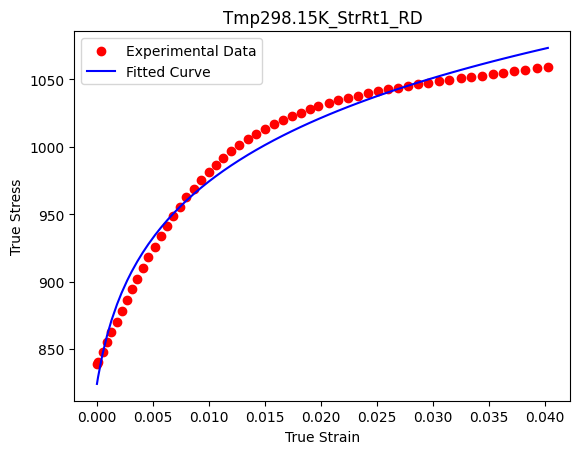

Fitted Parameters:
Alpha: 0.4350
A: 1357.8026
Epsilon_0: 0.0012
n: 0.0738
K0: 500.0000
B: 0.0000
Beta: 8.3029

Error Metrics:
MSE: 82.8171
RMSE: 9.1004
MAE: 8.1147
R-squared: 0.9823


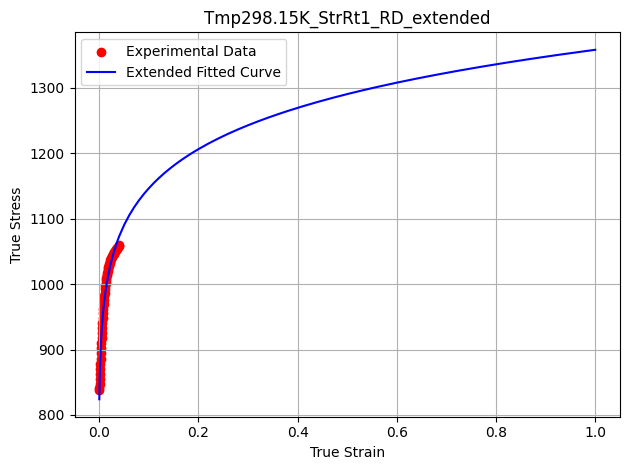

array([1.35780258e+03, 0.00000000e+00, 7.38315622e-02, 5.00000000e+02,
       1.15410672e-03, 4.34965399e-01, 8.30285108e+00])

In [4]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values

    # Define the Modified Swift-Voce equation
    def modified_swift_voce(strain, A, B, n, K, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = K * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([500, 0, 0, 500, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Weighted fitting to focus on specific regions
    scaling_factor = 50  # Adjust this factor to increase or decrease emphasis
    weights = weights = np.where(strain < 0.1, scaling_factor / np.sqrt(strain + 0.001)**0.03, 1 / (strain + 0.01)**0.75)

  # Squaring the term to emphasize lower strains more

    # Fit the curve with refined bounds and method
    params, _ = curve_fit(
        modified_swift_voce, strain, stress, p0=initial_guess, bounds=bounds, method='dogbox', sigma=weights
    )
    
    # Extract fitted parameters
    A, B, n, K, epsilon0, alpha, beta = params


    # Plot the experimental data and the fitted curve
    fitted_stress = modified_swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.show()

    # Print fitted parameters
    print(f'Fitted Parameters:\n'
          f'Alpha: {alpha:.4f}\n'
          f'A: {A:.4f}\n'
          f'Epsilon_0: {epsilon0:.4f}\n'
          f'n: {n:.4f}\n'
          f'K0: {K:.4f}\n'
          f'B: {B:.4f}\n'
          f'Beta: {beta:.4f}\n')

    # Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
    # Extended strain for comparison
    extended_strain = np.concatenate((strain, np.arange(strain[-1] + 0.01, 1.01, 0.01)))
    extended_stress = modified_swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Extended Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return params

condition = 'Tmp298.15K_StrRt1_RD'
analyze_msv_fit('Exp_FC_StrRtDpn_TmpDpn_RT.csv', condition + '_E', condition + '_S', condition)


# Plot of all strain rate at RT and parameters relationship

In [5]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']
#conditions = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD','Tmp298.15K_StrRt1_RD']
conditions = ['Tmp77.15K_StrRt0.0001_RD']
for condition in conditions:
    params.append(analyze_sv_fit('Exp_FC_StrRtDpn_TmpDpn_RT.csv', condition + '_E', condition + '_S', condition))


for i in range(7):
    plt.figure(figsize=(8, 5))  # Create a new figure for each plot
    plt.plot(conditions, [p[i] for p in params], marker='o')
    plt.xlabel('Conditions')
    plt.xticks(rotation=60)
    plt.ylabel(params_name[i])
    plt.title(params_name[i] + ' of Each Condition')
    plt.tight_layout()  # Adjust layout to prevent label cut-off
    plt.show()  # Display the plot

KeyError: 'Tmp77.15K_StrRt0.0001_RD_E'